# <center> Дипломный проект <br> Прогнозирование временных рядов трафика желтого такси Нью-Йорка

## <center>2 Визуализация данных на карте <br>

На этой неделе нам предстоит освоить работу с геоданными, научиться рисовать объекты на статистических и динамических картах, а также понять, для каких прямоугольных районов прогнозировать спрос на такси на самом деле нужно.

Поскольку мы агрегировали данные по равномерной сетке, можно ожидать, что существенное количество ячеек окажется в районах города, где вызов такси невозможен (реки, заливы, острова, парки). Теоретически ряды, соответствующие таким ячейка, должны состоять из одних нулей, но на практике это может быть не так: устройства, определяющие координаты автомобилей в момент начала поездки, несовершенны и могут ошибаться, показывая, например, что такси находится в середине реки. Чтобы правильно отобрать ячейки, вам понадобится визуализировать их границы на карте и отфильтровать те, из которых поездки на такси невозможны. 

### Загрузка модулей

In [16]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
#import folium
import geojson
import pickle
import geopandas

%matplotlib inline

### Загрузка ранее предобработанных данных за май 2016 года

In [2]:
data = pd.read_csv('data/Prepare_data/prepare_data_2016-05.csv', parse_dates=['time'])
data.head()

,time,region,count
0,2016-05-01,1015,1
1,2016-05-01,1017,1
2,2016-05-01,1029,3
3,2016-05-01,1030,1
4,2016-05-01,1033,4


### Общее количество поездок такси из каждой географической зоны

In [3]:
count_month = data.groupby('region').sum()
count_month.head()

,count
region,
1,0
2,0
3,0
4,0
5,0


In [4]:
print('Количество ячеек без поездок: {}'.format(count_month['count'].value_counts()[0]))

Количество ячеек без поездок: 1283


### Статическая карта Нью-Йорка

In [7]:
#Границы New-York
west, south, east, north = -74.25559, 40.49612, -73.70001, 40.91553

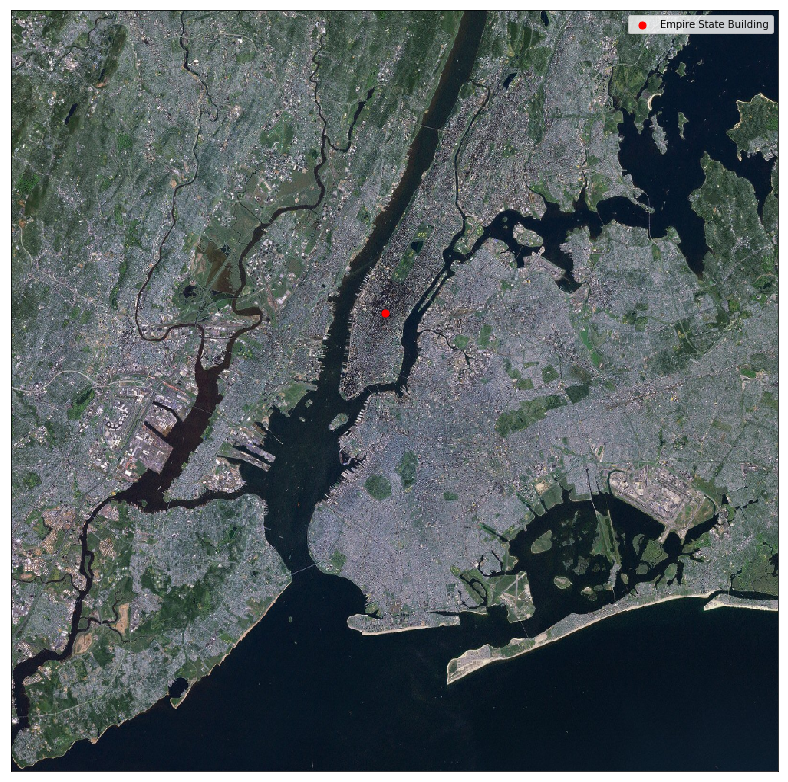

In [8]:
fig = plt.figure(figsize=(14,14))
static_map = Basemap(llcrnrlat=south, urcrnrlat=north, llcrnrlon=west, urcrnrlon=east, 
            projection='merc', resolution='c',epsg=2263)
static_map.arcgisimage(xpixels = 1000,ypixels = 1000)

#Empire State Building
static_map.scatter(-73.985428,40.748817,c='r', s=50, latlon = True, label='Empire State Building')
plt.legend()
plt.show()

### Визуализация данных на статической карте Нью-Йорка

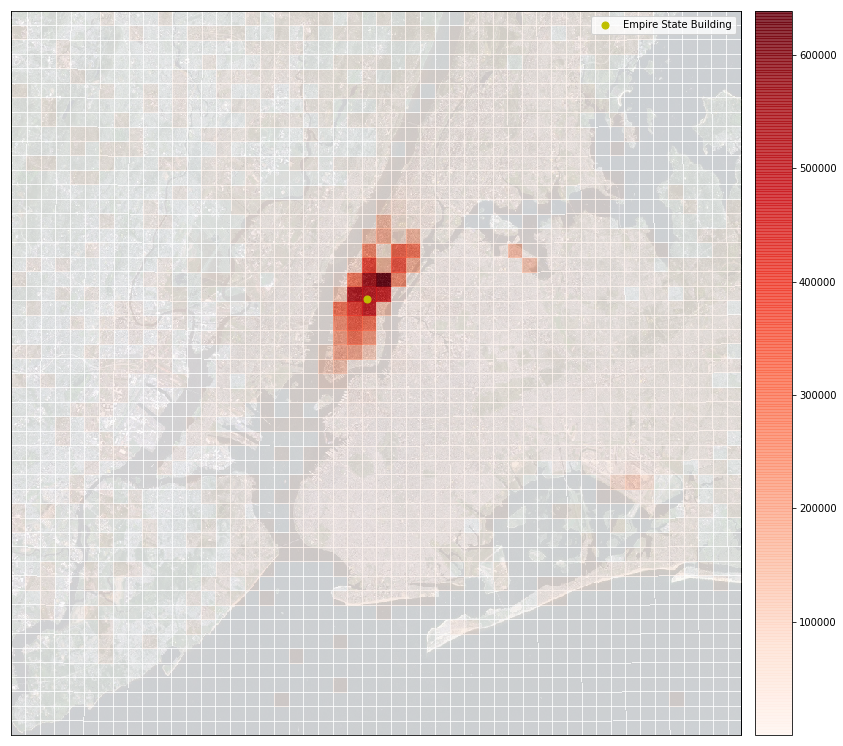

In [9]:
fig = plt.figure(figsize=(14,14))
my_cmap = plt.get_cmap('Reds')
my_cmap.set_under(color='white')
data_map = Basemap(llcrnrlat=south, urcrnrlat=north, llcrnrlon=west, urcrnrlon=east, 
            projection='merc', resolution='c', epsg=2263)
data_map.arcgisimage(xpixels = 1000,ypixels = 1000)
# Генерируем сетку и значения
lons, lats = np.meshgrid(np.linspace(west,east,num=51), np.linspace(south,north,num=51))
x,y = data_map(lons,lats)
count = count_month['count'].values.reshape((50,50),order='F')

data_map.pcolormesh(x,y,count,cmap = my_cmap,vmin=1,alpha=0.8)
data_map.colorbar()
data_map.scatter(-73.985428,40.748817,c='y', s=50, latlon = True, label='Empire State Building')
plt.legend()
plt.show()

### Интерактивная карта Нью-Йорка

In [10]:
m = folium.Map(location=[40.689170, -74.044440]) # Координаты Статуи Свободы
folium.Marker([40.689170, -74.044440], popup='<i>Statue of Liberty</i>').add_to(m)
m

#### Добавим на карту среднее за месяц количество поездок такси в час по ячейкам

In [5]:
# Число часов в месяцев
n_hours = data[data['region'] == 1].count()[0]
counts_per_hour = count_month / n_hours
counts_per_hour_without_0 = counts_per_hour[counts_per_hour['count'] > 0] # Удаляем ячейки с нулевыми значениями

In [6]:
# Преобразуем ячейки в формат geojson
regions = pd.read_csv('data/regions.csv',sep=';',index_col='region')
feature = []
# Ячейки только с ненулевыми значениями
for n in regions[counts_per_hour['count'] > 0].itertuples():
    coord = []
    # Образуем замкнутый полигон с id = номер ячейки
    coord.append((n[1],n[4]))
    coord.append((n[2],n[4]))
    coord.append((n[2],n[3]))
    coord.append((n[1],n[3]))
    coord.append((n[1],n[4]))
    feature.append(geojson.Feature(geometry=geojson.Polygon([coord]),id=n[0]))
feature_collection = geojson.FeatureCollection(feature)

In [15]:
m = folium.Map(location=[40.689170, -74.044440])
m.choropleth(geo_data=feature_collection, data=counts_per_hour_without_0['count'],fill_color='RdPu',
             fill_opacity=0.8,line_opacity=0.2,
             key_on='feature.id')
m

### Отфильтруем плохие ячейки

In [7]:
counts_per_hour_filt = counts_per_hour[counts_per_hour['count'] >= 5]
print('Количество оставшихся ячеек: {}'.format(counts_per_hour_filt.shape[0]))

Количество оставшихся ячеек: 102


### Проверим оставшиеся ячейки на карте

In [10]:
feature = []
for n in regions[counts_per_hour['count'] >= 5].itertuples():
    coord = []
    coord.append((n[1],n[4]))
    coord.append((n[2],n[4]))
    coord.append((n[2],n[3]))
    coord.append((n[1],n[3]))
    coord.append((n[1],n[4]))
    feature.append(geojson.Feature(geometry=geojson.Polygon([coord]),id=n[0]))
feature_collection_filt = geojson.FeatureCollection(feature)

NameError: name 'list_region' is not defined

In [18]:
m = folium.Map(location=[40.689170, -74.044440])
m.choropleth(geo_data=feature_collection_filt, data=counts_per_hour_filt['count'],fill_color='RdPu',
             fill_opacity=0.8,line_opacity=0.2,
             key_on='feature.id')
m

Данных стало значительно меньше и все оставшиеся ячейки находятся в доступных местах. В дальнейшем мы будем работать только с оставшимися ячейками.

In [34]:
list_region = list(counts_per_hour_filt.index)
with open('data/list_region.pkl', 'wb') as f:
    pickle.dump(list_region, f)

Также сохраним полученную сетку координат в файл:

In [35]:
mesh = geopandas.GeoDataFrame.from_features(feature_collection_filt)
mesh['region'] = list_region
with open('data/mesh.pkl', 'wb') as f:
    pickle.dump(mesh, f)